# Cross-resonance gate between a transmon and a fluxonium: strong drive regime

In this notebook we study the cross-resonance effect between a transmon and a fluxonium in the strong drive regime.

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cr as util
import copy
import json
import cmath

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b) = i q_{ZPF} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z X$ term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency does not seem that promising. However, one might evaluate using Raman transitions.

# Introducing the qubits and the coupled system

In [2]:
with open('flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [3]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "1"

#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 10

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times= parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]

In [4]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

The basis principle behind the gate is illustrated in the following figure

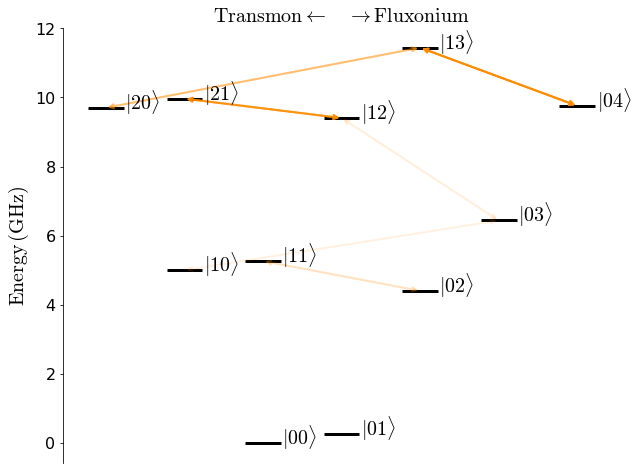

In [5]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util.energy_levels_diagram(bare_system, level_list, show_drive=False)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. 
We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\mu_{YZ} = \lvert \langle 10 | q_{F} | 00 \rangle - \langle 11 | q_{F} |01 \rangle \rvert $$
$$\mu_{Y} = \lvert \langle 10 | q_{F} | 00 \rangle + \langle 11 | q_{F} |01 \rangle \rvert $$

The second term quantifies the gate speed. Notice that if the phase of the drive is $0$ one hase a $YZ$ term from the charge operator. 

For the given parameters we have

In [6]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [7]:
display(Latex(r'$f_{{flx}} = {:.3f} \, \mathrm{{MHz}}$'.format(flx_freq*1e3)))
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{IY}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

However this is a sensible analysis only at low drive strengths. Taking only the first 3 levels of the transmon and the first 4 of the fluxonium and in an interaction picture with 
$$
H_0 = \omega_d |1 \rangle \langle 1 |_T + 2 \omega_d |2 \rangle \langle 2 |_T + \omega_d |1 \rangle \langle 1 |_F +  \omega_d |3 \rangle \langle 3 |_F +  2 \omega_d |2 \rangle \langle 2 |_F
$$
the Hamiltonian in the Rotating-Wave approximation is

$$
H_I = (\omega_T - \omega_d)|1 \rangle \langle 1 |_T + (\delta_T + 2(\omega_T - \omega_d))  |2 \rangle \langle 2 |_T + (\omega_{F,1} - \omega_d)|1 \rangle \langle 1 |_F + (\omega_{F,3} - \omega_d)|3 \rangle \langle 3 |_F + (\omega_{F,2} - 2 \omega_d)|2 \rangle \langle 2 |_F + J_C q_{ZPF}\biggl[\biggl(|1 \rangle \langle 0 |_T + \sqrt{2}|2 \rangle \langle 1 |_T  \biggr) \biggl(q_{10}|0 \rangle \langle 1 |_F + q_{30}|0 \rangle \langle 3 |_F + q_{21} |1 \rangle \langle 2 |   \biggr) + \mathrm{h.c.} \biggr] + \frac{\varepsilon_d}{2}i \biggl(q_{10} |1 \rangle \langle 0 | + q_{30} |3 \rangle \langle 0 | +  q_{21} |2 \rangle \langle 1 | - \mathrm{h.c.}    \biggr)
$$

In what follows we introduce this Hamiltonian directly in Qutip

In [8]:
freq_drive = transm.max_freq
eps_drive = 1.0


flx_state = {}
for lev in range(0, 4):
    state_tmp = flx.eig_states(4)[1][lev]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    flx_state[str(lev)] = state_tmp

In [9]:
# Transmon Hamiltonian
lev_t = 3
lev_f = 4
id_t = qtp.qeye(lev_t)
id_f = qtp.qeye(4)
proj_1_t = qtp.basis(lev_t, 1)*qtp.basis(lev_t, 1).dag()
proj_2_t = qtp.basis(lev_t, 2)*qtp.basis(lev_t, 2).dag()
h_t_single = (transm.max_freq - freq_drive)*proj_1_t + (transm.anharm + 2*(transm.max_freq - freq_drive))*proj_2_t
h_t = qtp.tensor(h_t_single, id_f)

# Fluxonium Hamiltonian
omega_flx = flx.eig_energies(lev_f) - flx.eig_energies(lev_f)[0] 
proj_1_f = qtp.basis(lev_f, 1)*qtp.basis(lev_f, 1).dag()
proj_2_f = qtp.basis(lev_f, 2)*qtp.basis(lev_f, 2).dag()
proj_3_f = qtp.basis(lev_f, 3)*qtp.basis(lev_f, 3).dag()
h_f_single = (omega_flx[1] - freq_drive)*proj_1_f + (omega_flx[3] - freq_drive)*proj_3_f + \
            (omega_flx[2] - 2*freq_drive)*proj_2_f
h_f = qtp.tensor(id_t, h_f_single)

# Coupling Hamiltonian
coup_op_t = transm.charge_zpf*(qtp.basis(lev_t, 1)*qtp.basis(lev_t, 0).dag() + np.sqrt(2)*qtp.basis(lev_t, 2)*qtp.basis(lev_t, 1).dag())
q_10 = np.imag(get_mat_elem(flx.charge_op(), flx_state["1"], flx_state["0"]))
q_21 = np.imag(get_mat_elem(flx.charge_op(), flx_state["2"], flx_state["1"]))
q_30 = np.imag(get_mat_elem(flx.charge_op(), flx_state["3"], flx_state["0"]))
coup_op_f = q_10*qtp.basis(lev_f, 0)*qtp.basis(lev_f, 1).dag() + q_30*qtp.basis(lev_f, 0)*qtp.basis(lev_f, 3).dag() + \
            q_21*qtp.basis(lev_f, 1)*qtp.basis(lev_f, 2).dag()
h_coup = jc*(qtp.tensor(coup_op_t, coup_op_f) + qtp.tensor(coup_op_t, coup_op_f).dag())
 
# Drive Hamiltonian
h_drive = eps_drive/2*1j*(qtp.tensor(id_t, coup_op_f).dag() - qtp.tensor(id_t, coup_op_f))

#Total Hamiltonian
h_0 = h_t + h_f
h = h_t + h_f + h_coup
h_tot = h_t + h_f + h_coup + h_drive

In [10]:
eig_en, eig_states = h.eigenstates()
eig_en_tot, eig_states_tot = h_tot.eigenstates()

In [11]:
def dressed_state(
    lev: str,
    hamil: qtp.qobj.Qobj(),
    lev_t: int,
    lev_f: int
):
    """
    Description
    ---------------------------------------------------------
    Function that returns the dressed state
    """
    
    #eig_en_0, eig_states_0 = h_0.eigenstates()
    eig_en, eig_states = hamil.eigenstates()
    
    lev_list = [int(index) for index in lev]
    
    if lev_list[0] >= lev_t or lev_list[1] >= lev_f:
        raise ValueError("Index error: indeces out of bound")
    state_0 = qtp.tensor(qtp.basis(lev_t, lev_list[0]), qtp.basis(lev_f, lev_list[1]))
    #en_0 = eig_en_0[state_index]
    eig_states_list = list(eig_states)
    state = eig_states_list[0]
    en = eig_en[0]
    fid = qtp.fidelity(state*state.dag(), state_0*state_0.dag())
    for state_tmp, en_tmp in zip(eig_states_list, eig_en):
        fid_tmp = qtp.fidelity(state_tmp*state_tmp.dag(), state_0*state_0.dag())
        if fid_tmp > fid:
            state = state_tmp
            fid = fid_tmp
            en = en_tmp
    loc = np.argmax(np.abs(np.array(state)) )
    phase = cmath.phase(state[loc])
    state = np.exp(-1j*phase)*state
    return en, state

To get the effective Hamiltonian we employ numerically an exact Schrieffer-Wolff. All we need to do is define the projectors
involved in the SW transformation

In [12]:
def zz_drive(
    hamil,
    lev_t: int,
    lev_f: int
) -> float:
    en_00 = dressed_state('00', hamil, lev_t, lev_f)[0]
    en_01 = dressed_state('01', hamil, lev_t, lev_f)[0]
    en_10 = dressed_state('10', hamil, lev_t, lev_f)[0]
    en_11 = dressed_state('11', hamil, lev_t, lev_f)[0]
    xi_zz = en_00 + en_11 - en_01 - en_10
    return xi_zz

def project_dressed(
    op: qtp.qobj.Qobj(),
    hamil: qtp.qobj.Qobj(),
    lev_t: int,
    lev_f: int
):
    op_proj = np.zeros([4, 4], dtype=complex)
    states = {}
    states["00"] = dressed_state('00', hamil, lev_t, lev_f)[1]
    states["01"] = dressed_state('01', hamil, lev_t, lev_f)[1]
    states["10"] = dressed_state('10', hamil, lev_t, lev_f)[1]
    states["11"] = dressed_state('11', hamil, lev_t, lev_f)[1]
    
    for key_row, row in zip(states.keys(), range(0, 4)):
        for key_col, col in zip(states.keys(), range(0, 4)):
            op_proj[row, col] = op.matrix_element(states[key_row], states[key_col])
    
    return op_proj

def projector(
    hamil: qtp.qobj.Qobj(),
    lev_t: int,
    lev_f: int,
    labels=["00", "01", "10", "11"]
):
    states = {}
    proj = 0
    for label in labels:
        states[label] = dressed_state(label, hamil, lev_t, lev_f)[1]
        proj += states[label]*states[label].dag()
    return proj, states

In [13]:
proj_dressed, states_dressed = projector(h, lev_t, lev_f)
proj_dressed_drive, states_dressed_drive = projector(h_tot, lev_t, lev_f)
ref_dressed = qtp.tensor(id_t, id_f) - 2*proj_dressed
ref_dressed_drive = qtp.tensor(id_t, id_f) - 2*proj_dressed_drive
u_sw = (ref_dressed*ref_dressed_drive).sqrtm()

In [14]:
def h_sw_exact(
    proj_0: qtp.qobj.Qobj(),
    proj: qtp.qobj.Qobj(),
    hamil: qtp.qobj.Qobj(),
    states_0: dict,
    lev_t: int,
    lev_f: int
    
):
    refl_0 = qtp.tensor(qtp.qeye(lev_t), qtp.qeye(lev_f)) - 2*proj_0
    refl = qtp.tensor(qtp.qeye(lev_t), qtp.qeye(lev_f)) - 2*proj
    u_sw = (refl_0*refl).sqrtm()
    h_sw = u_sw*hamil*u_sw.dag()
    h_eff = np.zeros([4, 4], dtype=complex)
    for key_row, row in zip(states_0.keys(), range(0, 4)):
        for key_col, col in zip(states_0.keys(), range(0, 4)):
            h_eff[row, col] = hamil.matrix_element(states_0[key_row], states_0[key_col])
    return h_eff

In [15]:
h_sw_eff = h_sw_exact(proj_dressed, proj_dressed_drive, h_tot, states_dressed, lev_t, lev_f)

The easiest thing is to obtain the projector on the dressed basis without the drive

In [16]:
def get_pauli_coeff(
    op: np.ndarray,
    label: str
):
    pauli = {}
    pauli["I"] = np.identity(2, dtype=complex)
    pauli["X"] = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
    pauli["Y"] = np.array([[0.0, -1j*1.0], [1j*1.0, 0.0]], dtype=complex)
    pauli["Z"] = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    label_list = [x for x in label]
    pauli_op = np.kron(pauli[label_list[0]], pauli[label_list[1]])
    coeff = 1/4*np.trace(op.conj().T.dot(pauli_op))
    return coeff

In [17]:
get_pauli_coeff(h_sw_eff, "YZ")*1e3*2

(-4.381421618227143+0j)

In [18]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [19]:
mu_yz_flx(comp_states, coupled_sys['F'].charge_op())*eps_drive*1e3

-4.14866991947721

There seems to be a mysterious factor of 2